## Modelling Mathematical Theorems
### Goals
* Determine if there is a trend among theorems of similar fields of Mathematics
* What are the most similar fields of Mathematics
* Build a predictive model to determine a field by commonly used words

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from urllib2 import Request, urlopen, HTTPError
from sklearn.neighbors import NearestNeighbors
from wordcloud import WordCloud, STOPWORDS
from nltk.stem.porter import PorterStemmer
from urlparse import urlunparse, urlparse
from nltk.corpus import wordnet as wn
from matplotlib import pyplot as plt
from bs4 import BeautifulSoup
import scipy.stats as stat
from nltk import corpus
import plasTeX as tex                                             # For Parsing TeX in Wikipedia 
import requests_cache
import pandas as pd
import scipy as sci
import numpy as np
import wordcloud
import nltk
import json 
import re

%matplotlib inline
plt.style.use('ggplot')
requests_cache.install_cache('coll_cache')

### Scraping the Theorems

To get the Math Theorems, we scraped the Wikipedia page <a href="https://en.wikipedia.org/wiki/List_of_theorems">List of Theorems</a>. From here we recognized that there was a standard <tt>mw-content-ltr</tt> class in which the body of each page was located in. The following scapes the List of Theorems page, removes the header and footer, and then builds a data frame by scraping the pages of each of the theorems.

In [ ]:
url = 'https://en.wikipedia.org/wiki/List_of_theorems'
html = urlopen(url)
soup = BeautifulSoup(html,'html.parser')
sections = soup.find_all('li')
sections = sections[37:1152] # Remove Header and Footer

In [ ]:
theorems = {'Field':[],'Title':[],'Link':[],'Page':[]}
for temp in sections:
    link = temp.find('a')
    cat = temp.find('i')
    if (cat == None):
        if (re.search(r'\(.*?\)',link.get('title')) == None):
            cat = ''
        else:
            cat = re.sub('\(|\)','',re.search(r'\(.*?\)',link.get('title')).group())
    else:
        cat = cat.get_text().lower()

    try:
        html = urlopen("https://en.wikipedia.org"+str(link.get('href')))
        page = BeautifulSoup(html,'html.parser')
    except HTTPError as e:  
        page = e

    theorems['Field'].append(cat)
    theorems['Title'].append(link.get('title'))
    theorems['Link'].append(link.get('href'))
    if type(page) == HTTPError:
        theorems['Page'].append(page)
    else:
        theorems['Page'].append(page.find(class_='mw-content-ltr'))
theorems = pd.DataFrame(theorems)
theorems.to_csv("theorems.txt",sep=',',encoding='utf-8') # Use encoding because of scaped pages
print theorems.shape

#### Data Pre-Processing

Once we had the html of each of the theorems, we needed to clean this text substantially in order analyze it. To do this we first replaced any unicode titles with their <tt>string</tt> equivalents, then we trimmed any theorems that were part of obscure fields of Mathematics (for example Lie Algebra, Metric Geometry, or Elliptic Differential Equations).

In [ ]:
## Clean up the table (get rid of Unicode titles)
for field in theorems['Field']:
    try:
        str(field)
    except UnicodeEncodeError as e:
        print field
theorems['Field'][['quantum theory' in x for x in theorems['Field']]] = 'quantum theory'
theorems['Field'][['clebsch' in x for x in theorems['Field']]] = 'clebsch gordan coefficients'
theorems['Field'] = [str(x) for x in theorems['Field']]

## Removes Theorems in Categories with only min_cnt entries
min_cnt = 4
good_fields = list(theorems.groupby('Field').count()[theorems.groupby('Field').count()['Link'] > min_cnt].index) 
duplicate_theorems = theorems[[(x in good_fields) for x in theorems['Field']]]
n = duplicate_theorems.shape[0]

Still, we can't train the the html data as is. First, this data has all the html formatting tags such as <"p"> and <"div">. Beautiful Soup remove's these by the <tt>.get_text()</tt> function. Second, this is Mathematics and as such it contains a substantial amount of Math in each of the pages. Not only is this math not easily translated into words, it is formatted by the standard <tt>TeX</tt> formatting which looks like <tt>\forall x \in \mathbb{R}<\tt> to produce $\forall x \in \mathbb{R}$. To fix this we first removed the html formatting with get_text(), then used regular expressions to remove any brakets or other formatting that is present in a standard TeX script. However, this still left the above expression as <tt> forall x in mathbb R </tt>.

In [ ]:
trimmed = [" ".join([x for x in page.get_text().split() if re.search('\{*\}|\(*\)|\$*\$|\(|\)|\{|\}',x) == None]) for page in duplicate_theorems['Page']]
duplicate_theorems.loc[:,'Trimmed'] = trimmed
duplicate_theorems[0:5]

To remove the extraneous words that were part of the TeX commands, we scraped a LaTeX glossary of commands and added these words to our collection of stopwords (used later for classification and word clouds). This glossary can be found <a href="https://en.wikibooks.org/wiki/LaTeX/Command_Glossary">here</a>.

In [ ]:
latexUrl = 'https://en.wikibooks.org/wiki/LaTeX/Command_Glossary'
try:
    latex_html = urlopen(latexUrl)
    soup = BeautifulSoup(latex_html,'html.parser')
except HTTPError as e:  
    print e
tex_words = []
bad_chars = r'[\\|\xc2|\x99|\xa0|{|}]'
for cat in soup.find_all('dl'):
    for word in soup.find_all('dt'):
        try:
            tex_words.append(str(re.sub(bad_chars,'',word.get_text()[1:])).lower())
        except UnicodeEncodeError as e:
            print word
        except IndexError as e:
            print word

stopwords = ['will','the','and','that','said',
             'from','they','their','this','year','ext',
             'mathbb','true','false','displaystyle','wikipedia',
             'ready','user','mediawiki','mw','value','theorem',
             'number','lemma','template','en','k_','cdot','x_',
             'pmod','styles','window','gadget','module','a_','rlq',
             'edit','system','varphi','mathbf','function','wikimedia',
             'scriptstyle','doi','references','mathrm']+tex_words

### Most Common Words

Next we used the nltk package to build word clouds and bar graphs of the most common words across all theorems in a given field of Mathematics. The following is a few functions used in this process.

In [ ]:
stemmer = PorterStemmer().stem
tokenize = nltk.word_tokenize

def remove_small(series,min_len = 3):
    """
        Removes any words less than or equal to min_len. Returns
        a block of text of all these words to be input into NLTK.
    """
    text = []
    [[text.append(y) for y in x.split()] for x in series]
    text = pd.DataFrame({'text':text})
    return(" ".join(text.iloc[[len(x)>min_len for x in text['text']]]['text']))

def stem(tokens,stemmer = PorterStemmer().stem):
    """
        Calls the nltk PorterStemmer() on a lowercase version 
        of a list of tokens. 
    """
    return [stemmer(w.lower()) for w in tokens] 

def lemmatize(text,stopwords=['']):
    """
    Extract simple lemmas based on tokenization and stemming
    Input: string
    Output: list of strings (lemmata)
    """
    #text = remove_small([text],min_len)
    return stem([x for x in tokenize(text) if x.lower() not in stopwords])

def build_wordcloud(text,stopwords,ax=plt,title=''):
    """
        Helper function for building a wordcloud with appropriate 
        title and formatting. Also returns the wordcloud as a 
        data frame of each word and its associated frequency.
    """
    wordcloud = WordCloud(stopwords = stopwords).generate(text)
    ax.imshow(wordcloud)
    ax.axis("off")
    ax.show() if ax == plt else ''
    ax.set_title(title) if ax != plt else ''
    words = WordCloud(stopwords = stopwords).process_text(text)
    words = pd.DataFrame({'Words':words.keys(),'Freq':words.values()}).sort_values('Freq',ascending=0)    
    return(words)

def f(text,ax=plt,stopwords=[''],min_len=7,title=None): 
    """
       Helper function for build_wordcloud that adds the 
       title to the list of stopwords and removes and small
       words with remove_small first.
    """
    if (title == None):
        title = text.iloc[0,0]
    texts = [y.lower() for y in text['Trimmed']]
    words=build_wordcloud(stopwords=stopwords+title.split(' '),text=remove_small(texts,min_len),ax=ax,title=title)
    return(words)

We then built word clouds and bar graphs of the most common words in each field. 

In [ ]:
min_len = 6
grp = duplicate_theorems.groupby('Field')
fields = grp.apply(lambda x: x.iloc[0,0])
topwords = {}
for j in range(int(np.ceil(float(len(grp))/4.0))):
    f1,ax1 = plt.subplots(1,4,figsize = [20,10])
    f2,ax2 = plt.subplots(1,4,figsize = [20,3])
    for i in xrange(4):
        field = fields[i+4*j] if i+4*j < len(grp) else fields[-1]
        temp = duplicate_theorems[duplicate_theorems['Field']==field]
        txt=f(temp,ax1[i],stopwords=stopwords,min_len=min_len)
        txt[0:10].set_index('Words').plot(kind='bar',ax=ax2[i],title=field)
        topwords[field] = txt        

### Similarity of Fields

Next we measured the similarity of each field of Mathematics based on each fields most common words. The following builds a dictionary that provides a list of which fields of Math contain the Key in their most common words.

In [ ]:
textd = {}                                              # dictionary from lemmata to document ids containing that lemma
freqd = {}
min_freq = 5
for field in topwords.keys():
    freqd.update({field:sum(topwords[field]['Freq'][topwords[field]['Freq'] > min_freq].values)})
    t = " ".join(topwords[field]['Words'][topwords[field]['Freq'] > min_freq])    
    s = set(lemmatize(t,stopwords))
    try:
        toks = toks | s
    except NameError:
        toks = s
    for tok in s:
        try:
            textd[tok].append(field)
        except KeyError:
            textd[tok] = [field]

This dictionary is then turned into a data frame, below shows how many fields have the Keys as part of their top words. Below is a list of the ten most shared words among the fields.

In [ ]:
textd_save = textd
min_len = 4
textd = {key:vals for key,vals in textd_save.items() if len(key) > min_len}
print len(textd_save.keys()),len(textd.keys())
temp = pd.DataFrame({'Keys':textd.keys(), 'Length':[len(y) for y in textd.values()]}).sort_values('Length',ascending=False)
temp[0:10]

In [ ]:
def get_max_sim(C):
    """
        Returns the df of the most similar articles for a given corpus class. 
        Also returns a corpus for that df.
    """
    A = C
    temp = {'Max':[],'Argmax':[]}
    for i in range(A.shape[0]):
        temp['Argmax'].append((A.getcol(i)[range(i)+range(i+1,A.shape[0])]).A.argmax())
        temp['Max'].append((A.getcol(i)[range(i)+range(i+1,A.shape[0])]).max())
    df = pd.DataFrame(temp,index=range(A.shape[0])).sort_values(['Max'],ascending = 0)
    df['Field_1'] = np.array(fields)[df.index.values]
    df['Field_2'] = np.array(fields)[df['Argmax']]
    return(df)

def all_combos(seq):
    """
        Given a seq, returns all possible subsets of this sequence,
        with length equal to 2 and disregards order.
        Ex: all_combos([1,2,3]) = {[1,2],[1,3],[2,3]}
    """
    s = []
    for i in range(len(seq)):
        for j in range(i+1,len(seq)):
            s = s + [[seq[i],seq[j]]]
    return s

For $n$ total fields and $\nu$ total words, the similarity matrix for the fields of Mathematics, $Sim = [s_{ij}] \in \mathbb{R}^{n\times n}$, is given by,

$$s_{ij} = \frac{\sum_{k=1}^\nu \gamma_{ij}(w_k) }{\sqrt{2m_i m_j}};\quad\quad \gamma_{ij} = \left\lbrace
\begin{matrix} 
1&\text{if}&w_k\in F_i \cap F_j \\
0&\text{if}&i=j\\
0&\text{if}&w_k\notin F_i\cap F_j\
\end{matrix}\right.$$

where $F_i$ is the set of words for Field $i$, $w_k$ is the $k$th word, and $\beta$ is a scaling factor to force $s_{ij}\in [0,1]$. Below computes that similarity matrix and displays it as a graph of intensity. 

In [ ]:
n = max([len(x) for x in textd.values()])
combos = {}
for i in xrange(n+1):
    combos[i] = all_combos(xrange(i)) 
print {'Max{Fields per Word}:': n}

sim = np.zeros([len(fields),len(fields)])
field_key = {x[1]:x[0] for x in enumerate(fields)}

for key,val in textd.items():
    s = combos[len(val)]
    for indx in s:
        total_freq = np.sqrt(2*float(freqd[val[indx[0]]]+freqd[val[indx[1]]]))
        sim[field_key[val[indx[0]]],field_key[val[indx[1]]]] += float(1)/total_freq
        sim[field_key[val[indx[1]]],field_key[val[indx[0]]]] += float(1)/total_freq

import seaborn as sns
#sns.heatmap(sim, vmax=1, square=True)

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(sim, cmap=cmap, vmax=1,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5})


max_sim = get_max_sim(sci.sparse.csr_matrix(sim))
max_sim[0:4]

### Classifying Field of Mathematics

Next we built a classifer to predict the field of Mathematics that a theorem belongs to. We tested using bag of words or just the top words of each field with both Multinomial Naive Bayes and SVM models. 

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
import random

def performance(true, pred,P=1):
    """
        Computes the True Positive, False Positive, True Negative, 
        and False Negative of a prediction.
    """
    TP = FP = TN = FN = 0
    for x,y in zip(true,pred): 
        if x==y==P:
           TP += 1
        if y==P and x!=y:
           FP += 1
        if y!=P and x==y:
           TN += 1
        if y!=P and x!=y:
           FN += 1

    return(TP, FP, TN, FN)

def test_clf(df,clf,topwords,top_x=15):
    """
        Tests a clf model for a given choice of using the top_x 
        most common words of a field.
    """
    if topwords != None:
        df.data = [" ".join(topwords[field]['Words'][0:top_x].values) for field in df.target_names]
    
    indx = range(df.shape[0])
    random.shuffle(indx)
    trainSz = int(np.floor(0.5*len(indx)))
    train_indx, test_indx = indx[:trainSz],indx[trainSz:]
    train_thm, test_thm = df.iloc[train_indx,:], df.iloc[test_indx,:]

    import sklearn.datasets
    train = sklearn.datasets.base.Bunch(
                    description=train_thm.description,
                    filenames=train_thm.filenames,
                    target_names=train_thm.target_names,
                    data=train_thm.data,
                    target=train_thm.target)

    test = sklearn.datasets.base.Bunch(
                    description=test_thm.description,
                    filenames=test_thm.filenames,
                    target_names=test_thm.target_names,
                    data=test_thm.data,
                    target=test_thm.target)

    clf = clf.fit(train.data, train.target)
    predicted = clf.predict(test.data)

    TP, FP, TN, FN = np.mean([performance(test.target, predicted,i) for i in set(predicted)],axis=0)
    acc = np.mean(predicted == test.target)    
    sens = TP/(TP+FN) if TP+FN > 0 else float('Inf')
    spec = TN/(FP+TN) if FP+TN > 0 else float('Inf')
    prec = TP/(TP+FP) if TP+FP > 0 else float('Inf')
    fall = FP/(FN+TN) if FN+TN > 0 else float('Inf')
    cm = {'Accuracy':acc,'Sensitivity':sens,
          'Specificity':spec,'Precision':prec,'Fallout':fall}
    return(cm)

NB  = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB()),
])
SVM = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, n_iter=5, random_state=42)),
])
new_duplicate = duplicate_theorems.iloc[range(37)+range(38,duplicate_theorems.shape[0]),:].copy()
new_duplicate['target'] = [field_key[x] for x in new_duplicate.Field]
new_duplicate.columns = ['target_names','filenames','Page','description','data','target']

#### Fitting Models to Bag of Words

Using a bag of words as a feature set we check both the Multinomial Naive Bayes (MNB) and SVM models. The SVM model fits multiple classes in 1 vs all fashion as it is a binary classifier. Hence it checks each Theorem against each field and returns the most likely field.

In [ ]:
temp = test_clf(new_duplicate,NB,None)
print 'MNB:',{x:round(y,4) for x,y in temp.items()}

svm_cm = test_clf(new_duplicate,SVM,None)
print 'SVM:',{x:round(y,4) for x,y in svm_cm.items()}

Since the accuracy was significantly lower than desired, but the SVM model was clearly better than the MNB model. We then tuned the SVM model's hyper-parameters using a grid search in order produce the best model.

In [ ]:
grid_svm = {'alpha':[],'n_iter':[],'rand_state':[] ,'Accuracy':[],'Precision':[],'Sensitivity':[],'Specificity':[]}
for alpha in [1e-14,1e-12,1e-10,1e-8,1e-6,1e-4,1e-2]:
    for n_iter in [3,8,13,18,23,28,33]:
        for rnd in [20,40,60,80]:
            SVM = Pipeline([('vect', CountVectorizer()),
                            ('tfidf', TfidfTransformer()),
                            ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=alpha, n_iter=n_iter, random_state=rnd)),
            ])
            temp1 = test_clf(new_duplicate,SVM,None)
            grid_svm['alpha'].append(alpha)
            grid_svm['n_iter'].append(n_iter)
            grid_svm['rand_state'].append(rnd)            
            grid_svm['Accuracy'].append(temp1['Accuracy'])
            grid_svm['Precision'].append(temp1['Precision'])
            grid_svm['Sensitivity'].append(temp1['Sensitivity'])
            grid_svm['Specificity'].append(temp1['Specificity'])

In [ ]:
grid_df = pd.DataFrame(grid_svm)
grid_df['AdjustedMean'] = grid_df[['Accuracy','Specificity','Sensitivity','Precision']].mean(axis=1).values
grid_df.plot(kind='scatter',x='alpha',y='n_iter',c = 'AdjustedMean',logx=True)

best_alpha, best_n_iter, best_rnd = grid_df.sort_values('AdjustedMean',ascending = 0)[['alpha','n_iter','rand_state']].iloc[0,:]
print {'Best Alpha':best_alpha,'Best Num Iter':best_n_iter,'Best Random State':best_rnd}

#### Running Multinomial Naive Bayes on Top Words

Next we tried running the models on just the top words of each field rather than the whole bag of words approach. Since this produces a new hyper-parameter, <tt>top_x</tt>, which dictates how many of the top words are used in the model. Using this hyper-parameter, we built ROC and Precision-Recall curves as well as plotted the accuracy for the various values of <tt>top_x</tt>. 

In [ ]:
temp = test_clf(new_duplicate,NB,topwords,15)
print {x:round(y,4) for x,y in temp.items()}

indx = range(1,40,1)
temp1 = [test_clf(new_duplicate,NB,topwords,i) for i in indx]

CM = {'Accuracy'   :[x['Accuracy']    for x in temp1],
      'Precision'  :[x['Precision']   for x in temp1],
      'Sensitivity':[x['Sensitivity'] for x in temp1],
      'Specificity':[x['Specificity'] for x in temp1],
      'Fallout'    :[x['Fallout']     for x in temp1]}

_,ax = plt.subplots(1,3,figsize = [15,5])
_=pd.DataFrame(CM).plot(kind = 'scatter',y = 'Precision',x = 'Sensitivity',ax=ax[0],color = 'red',title='ROC Curve')
_=pd.DataFrame(CM).plot(kind = 'scatter',y = 'Sensitivity',x = 'Fallout',ax=ax[0],color = 'blue')
_=ax[0].legend(labels=['Prec-Recall','ROC'])
_=ax[0].plot([0, 1], [0, 1], 'k-', lw=2)

_=pd.DataFrame(CM['Accuracy']).plot(ax=ax[1],title='Accuracy vs. Top_X')
plt.xlabel('Top_X'), plt.ylabel('Accuracy')

_=pd.DataFrame(CM['Accuracy']).plot(kind = 'kde',ax=ax[2],title='Accurace KDE')
plt.xlabel('Accuracy')

print {'Min: ' : str(min(CM['Accuracy'])),
       'Max: ' : str(max(CM['Accuracy'])),
       'Mean: ' : str(np.mean(CM['Accuracy']))}

### Running SVM on Top Words

After determining the best values for <tt> rand_state, n_iter,</tt> and <tt> alpha </tt> we ran the tuned SVM model on just the top words of each field tuning the <tt>top_x</tt> hyper-parameter to build the ROC curve.

In [ ]:
from sklearn.linear_model import SGDClassifier
SVM = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', SGDClassifier(loss='hinge', penalty='l2',
                                            alpha=best_alpha, n_iter=best_n_iter, random_state=int(best_rnd))),
                ])
svm_cm = test_clf(new_duplicate,SVM,topwords,15)
print {x:round(y,4) for x,y in svm_cm.items()}

indx = range(1,40,1)
temp1 = [test_clf(new_duplicate,SVM,topwords,i) for i in indx]

CM = {'Accuracy'   :[x['Accuracy']    for x in temp1],
      'Precision'  :[x['Precision']   for x in temp1],
      'Sensitivity':[x['Sensitivity'] for x in temp1],
      'Specificity':[x['Specificity'] for x in temp1],
      'Fallout'    :[x['Fallout']     for x in temp1]}

_,ax = plt.subplots(1,3,figsize = [15,5])
_=pd.DataFrame(CM).plot(kind = 'scatter',y = 'Precision',x = 'Sensitivity',ax=ax[0],color = 'red', title='ROC Curve')
_=pd.DataFrame(CM).plot(kind = 'scatter',y = 'Sensitivity',x = 'Fallout',ax=ax[0],color = 'blue')
_=ax[0].legend(labels=['Prec-Recall','ROC'])
_=ax[0].plot([0, 1], [0, 1], 'k-', lw=2)
_=pd.DataFrame(CM['Accuracy']).plot(ax=ax[1],title='Accuracy vs. Top_X')
_=pd.DataFrame(CM['Accuracy']).plot(kind = 'kde',ax=ax[2],title='Accuracy KDE')

print {'Min: ' : str(min(CM['Accuracy'])),
       'Max: ' : str(max(CM['Accuracy'])),
       'Mean: ' : str(np.mean(CM['Accuracy']))}

Here we see that the accuracy and ROC curve are far superior with the topwords SVM model over the MNB model. This could be partly due to the fact that MNB relies on the features (words) being independent from each other which is not necesarily a good assumption. This is because a theorems choice of wording could affect all other words in the Theorem. For example, a linear algebra theorem could discuss a function as a map or an operator depending on if it is a theorem discusses the linearity of functions, a map between two vector spaces, or a Hermitian operator. In all these cases, the theorem should clearly be classified as Linear Algebra but has vastly different wording. The SVM model makes no such assumption, and it quickly weights non-informative features to zero, leaving only the big words playing a role in the classification. This is seen as the accuracy quickly rises to nearly 100% at only about 7 top words while the MNB model needs 27 to get close to the same accuracy.

### The Most Beautiful Theorems

Following an article on the most "Beautiful" theorems of Mathematics from <a href=https://www.quora.com/Which-are-the-most-beautiful-mathematical-theorems-and-why target='_blank'>www.quora.com</a>, the following illustrates some traits of all these theorems as a collection. Quora asked people to consider the following when selecting theorems for the list

| Category | Description|
|----------|------------|
|_Generality_ | it is applicable to a wide variety of problems.|
|_Succinctness_|  it is expressible simply, in only a few words or equations.|
|_Originality_ | it expresses a surprising mathematical insight, or a connection between different areas of mathematics, that had not previously been widely suspected.|
|_Significance_ | it represents an important advance in mathematical knowledge, or resolves an important mathematical problem.|
|_Potency_ | it stimulates many new areas of mathematical research.|
|_Centrality_ | it is used in the proofs of many subsequent theorems.|
|_Independence_ | its proof depends on only a small number of previously established theorems, and preferably none.|

The theorems that were selected were
<center>
The Pythagorean Theoem (Geometry, Pythagoras),
Euclid's Theorem of the Infinitude of Primes (Number Theory, Euclid), The Minimax Theorem (Game Theory, John von Neumann),The Brouwer Fixed Point Theorem (Topology, Luitzen Brouwer),Cauchy's Residue Theorem (Complex Analysis, Augustin-Louis Cauchy),Fourier's Theorem (Function Theory, Joseph Fourier),The Halting Theorem (Computability Theory, Alan Turing),Gödel's Incompleteness Theorems (Mathematical logic/Metamathematics, Kurt Godel),Schubert's Prime Knot Factorization Theorem (Knot Theory, Horst Schubert),Cantor's Theorem (Set Theory/Transfinite Analysis, Georg Cantor),Fundamental Theorem of Algebra (Algebra)
</center>

For this web page, the Theorems and which category they satisfy from the above list are bolded. Thus by scraping the page for the <tt> <"b"> </tt> tag we can get the relevant information after trimming the header (first 7 lines). Moreover, to make the theorem titles match the pre-existing data theorems frame, we had to do some serious trimming. This is done be first correcting any spelling errors, i.e. theoem instead of theorem, and stripping trailing white spaces as well as 'The' from each title.

In [ ]:
## Scraping the Theorems and the considerations for each theorem
beau_url = 'https://www.quora.com/Which-are-the-most-beautiful-mathematical-theorems-and-why'
beau_soup = BeautifulSoup(urlopen(beau_url),'html.parser').find_all('b')[7:]
bolded = [x.get_text() for x in beau_soup if x.get_text()!='']
beau_thms  = [re.sub('Theorems|Theorem|Theoem','theorem', re.sub("The ",'', y)).strip() for y in bolded if re.search('theorem|theoem',y.lower())]
beau_terms = [y for y in bolded if re.search('theorem|theoem',y.lower())==None]
beau_dic = {x[0]:x[1] for x in zip(beau_thms,beau_terms)}
beau_dic

Even after trimming the titles, there were still some that were names differently than our data frame. For example, Residue theorem was called Cauchy's Residue theorem. So we had to correct these titles before searching our data frame for their text.

In [ ]:
# Trim Dictionary to match title names
beau_dic["Residue theorem"] = beau_dic.pop("Cauchy's Residue theorem")
beau_dic["Euclid's theorem"] = beau_dic.pop("Euclid's theorem of the Infinitude of Primes")
beau_dic["Brouwer fixed point theorem"] = beau_dic.pop("Brouwer Fixed Point theorem")
beau_dic[u"G\xf6del's incompleteness theorem"] = beau_dic.pop(u"G\xf6del's Incompleteness theorem")
beau_dic["Fundamental theorem of algebra"] = beau_dic.pop("theorem (Fundamental theorem of Algebra): Every polynomial [math]p : \\mathbb{C} \\rightarrow \\mathbb{C} [/math] of degree [math] n[/math] has [math] n [/math] roots (counting multiplicity) in [math] \\mathbb{C} [/math]")
beau_dic

After fixing the titles we could join this list of Beautiful Theorems with the associated "reasons" for being beautiful with our pre-existing data frame.

In [ ]:
# Build a Data frame using the beautiful theorems in duplicate_theorems
BeautifulThms = pd.concat([duplicate_theorems[duplicate_theorems['Title'] == x] for x in beau_dic.keys() if x in " ".join(duplicate_theorems['Title'])])
BeautifulThms['Reasons'] = [re.sub('\\.','',beau_dic[x]) for x in BeautifulThms['Title']]
BeautifulThms[0:3]

Then we plotted the most common words in all the Theorems that are deemed Beautiful. 

In [ ]:
# Build Wordclouds from all the Reasons
f1,axs = plt.subplots(1,2,figsize=[12,3])
texts = [str(BeautifulThms[BeautifulThms['Title']==x]['Trimmed'].values) for x in BeautifulThms['Title'].values]
temp = pd.DataFrame({'Trimmed':texts})
txt=f(temp,axs[0],stopwords=[],min_len=min_len,title = 'All')
_=txt.set_index('Words').plot(kind='bar',ax=axs[1],title='All')

In [ ]:
# Plot the word clouds and bar graph
f1,axs = plt.subplots(1,2,figsize = [20,5])
title = " ".join([re.sub('\xf6','o',y).lower() for y in " ".join(BeautifulThms['Title']).split()])
texts = [str(BeautifulThms[BeautifulThms['Title']==x]['Trimmed'].values) for x in BeautifulThms['Title'].values]
text = remove_small([x.lower() for x in (" ".join(texts)).split() if re.search("[0-9]",str(x))==None],min_len)
stopwords2=stopwords+title.split(' ')
wordcloud = WordCloud(stopwords = stopwords,font_path='/Library/Fonts/Apple Chancery.ttf').generate(text)
ax = axs[0]
ax.imshow(wordcloud)
ax.axis("off")
ax.set_title('Beautiful Theorems')
words = WordCloud(stopwords = stopwords).process_text(text)
words = pd.DataFrame({'Words':words.keys(),'Freq':words.values()}).sort_values('Freq',ascending=0)    
ax = axs[1]
_=plt.gcf().subplots_adjust(bottom=0.25)
_=words[0:10].set_index('Words').plot(kind='bar',title='Beautiful Theorems',ax=ax)

There isn't much that can be gained from these plots, but one interesting feature is that the word "proof" was by far the most common word, nearly doubling second place. This is pretty clear when you consider that a theorem must be proven, but more importantly this didn't show up in the other word clouds. Thus this likely demonstrates that there is minimal similarity between the Beautiful theorems.

In [1]:
BeautySim = {'T1':[], 'F1':[],'Key1':[],'T2':[],'F2':[],'Key2':[],'Sim':[],'R1':[],'R2':[]}
beauty_Key = {x:field_key[i] for x,i in enumerate(BeautifulThms['Field'])}
for cmb in combos[BeautifulThms.shape[0]]:
    x,y = cmb
    BeautySim['F1'].append(BeautifulThms.Field.values[x])
    BeautySim['F2'].append(BeautifulThms.Field.values[y])
    BeautySim['T1'].append(BeautifulThms.Title.values[x])
    BeautySim['T2'].append(BeautifulThms.Title.values[y])
    BeautySim['R1'].append(BeautifulThms.Reasons.values[x])
    BeautySim['R2'].append(BeautifulThms.Reasons.values[y])
    BeautySim['Key1'].append(beauty_Key[x])
    BeautySim['Key2'].append(beauty_Key[y])
    BeautySim['Sim'].append(sim[beauty_Key[x],beauty_Key[y]])

BeautySim = pd.DataFrame(BeautySim).sort_values('Sim',ascending=0)
BeautySim[0:3]

NameError: name 'BeautifulThms' is not defined

# SAY SOMETHING ABOUT THIS SIMILARITY

Next we looked at the most common "reasons" for beautfulness among the Theorems. We plotted two sets of plots; one for all the theorems, and one for just the most similar theorems. 

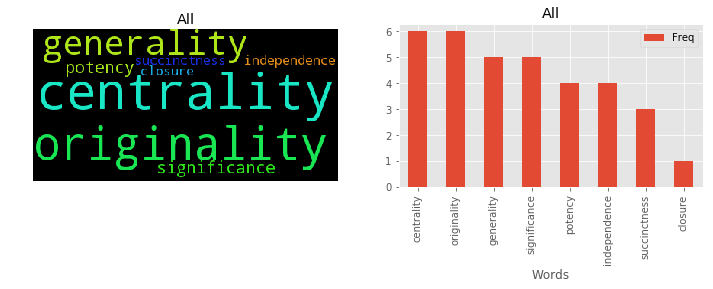

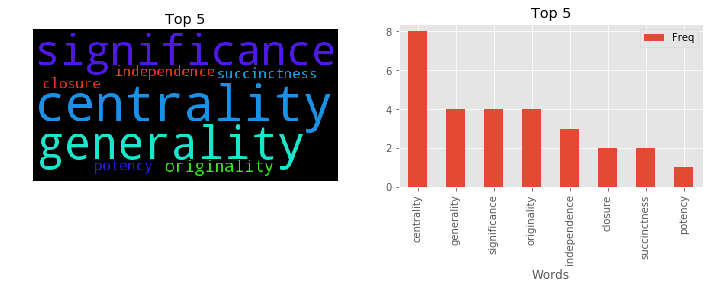

In [704]:
# Build Wordclouds from all the Reasons
f1,axs = plt.subplots(1,2,figsize=[12,3])
temp = pd.DataFrame({'Trimmed':[str(x) for x in BeautifulThms['Reasons'].values]})
txt=f(temp,axs[0],stopwords=[],min_len=min_len,title = 'All')
_=txt.set_index('Words').plot(kind='bar',ax=axs[1],title='All')

# Build Wordclouds from just the top 10 Reasons
f1,axs = plt.subplots(1,2,figsize=[12,3])
temp = pd.DataFrame({'Trimmed':[str(x) for x in (BeautySim['R1']+','+BeautySim['R2']).values[0:5]]})
txt=f(temp,axs[0],stopwords=[],min_len=min_len,title = 'Top 5')
_=txt.set_index('Words').plot(kind='bar',ax=axs[1],title='Top 5')

There weren't many words to begin with, but there is a clear divide between the two sets as far as distributions go. For the second plot, centrality towered over the the other reasons, while the first's words were all relatively the same frequency.

We then used our trained SVM model to learn more about the beautiful theorems. First we checked the accuracy of the model in correctly predicting their fields, and then we checked what field of Mathematics would be predicted by combining all the beautiful theorems into one. 

In [630]:
beauty_df = BeautifulThms.copy()
beauty_df['target'] = [field_key[x] for x in BeautifulThms.Field]
beauty_df.columns = ['target_names','filenames','Page','description','data','Reasons','target']

beauty_test = sklearn.datasets.base.Bunch(
                    description=beauty_df.description,
                    filenames=beauty_df.filenames,
                    target_names=beauty_df.target_names,
                    data=beauty_df.data,
                    target=beauty_df.target)

## Train on all the data
train = sklearn.datasets.base.Bunch(
                description=new_duplicate.description,
                filenames=new_duplicate.filenames,
                target_names=new_duplicate.target_names,
                data=new_duplicate.data,
                target=new_duplicate.target)

clf = SVM.fit(train.data, train.target)
predicted = clf.predict(beauty_test.data)

TP, FP, TN, FN = np.mean([performance(beauty_test.target, predicted,i) for i in set(predicted)],axis=0)
acc = np.mean(predicted == beauty_test.target)    
sens = TP/(TP+FN) if TP+FN > 0 else float('Inf')
spec = TN/(FP+TN) if FP+TN > 0 else float('Inf')
prec = TP/(TP+FP) if TP+FP > 0 else float('Inf')
cm = {'Accuracy':acc,'Sensitivity':sens,
      'Specificity':spec,'Precision':prec}
cm

{'Accuracy': 0.75,
 'Precision': 0.75,
 'Sensitivity': 0.29999999999999999,
 'Specificity': 0.95454545454545459}

Here wee see that the accuracy, precision, sensitivity, and specificity are all much less than the mean accuracy for the SVM model. This could be because there is a distinct difference between these "Beautiful" theorems and the standard formulaic theorems as a whole. Succinctness and originality were both categories in this list and both of these play against our model by not providing enough words and not providing similar words compared to other theorems in their respective fields. Moreover, theorems like the Fundamental Theorem of Algebra are about Algebra, but because these are the building blocks for Algebra all the algebraic tools built from them, so it requires the use of arithmetic and number theory in their proofs.

In [643]:
## Classify all the Beauty Theorems into one
beauty_all = sklearn.datasets.base.Bunch(
                    description="All Beautiful",
                    filenames="",
                    target_names="All",
                    data=[" ".join(beauty_df.data)],
                    target=-1)
predicted = clf.predict(beauty_all.data)
{x:y for x,y in enumerate(fields) if x == predicted}

{33: 'mathematical logic'}

Finally the overarching field that most represents all the Beautiful theorems as a whole in Mathematical Logic. Fitting as all of Mathematics pulls from this field. Hence, Mathematical logic would likely be a strong contender in a more subjective classification of the most beautiful theorems.

### Re-Categorizing Odd Fields

In the pre-processing step, we removed any theorems that were a part of some obscure field of Mathematics (per Wikipedia). The following will try to re-classify those Theorems into more appropriate fields so that they can be included with their fellow theorems. For example the field Quantum Theory really should be lumped in with Physics, and 'Several Complex Variables' is just Complex Analysis.

In [710]:
removed_fields = [x for x in theorems['Field'].unique() if x not in duplicate_theorems['Field'].unique()]

['theory of equations',
 'mathematical series',
 'lie algebra',
 'algebras',
 'complex manifold',
 'queueing theory',
 'real closed fields',
 'algebra',
 'elliptic differential operators',
 'fourier analysis',
 'metric spaces, differential equations',
 'spectral theory',
 'vector bundles',
 'category theory',
 'incidence geometry',
 'metric geometry',
 'several complex variables',
 'quantum theory',
 'prime numbers',
 'hardy spaces',
 'general topology',
 'algebra, combinatorics',
 'diophantine equation',
 'lattice theory',
 'electric power',
 'gamma function',
 'discrete geometry',
 'real analysis, calculus',
 'representation theory of finite groups',
 'discrete mathematics',
 'conics',
 'dimensional analysis',
 'theoretical computer science',
 'symplectic topology',
 'ordinary differential equations',
 'conformal mapping',
 'convex hull',
 'fixed points',
 'fibonacci numbers',
 'thermodynamics',
 'lie group',
 'structural analysis',
 'projective geometry',
 'disambiguation',
 'finite

# ------------------------TEST-------------------------------------

In [89]:
test_url = 'http://ac.els-cdn.com/055032138490052X/1-s2.0-055032138490052X-main.pdf?_tid=2c155508-082a-11e7-be50-00000aacb35e&acdnat=1489436468_7222e1ef8a50bfec8c9ea955f76a5c1e'

In [90]:
try:
    latex_html = urlopen(test_url)
    soup = BeautifulSoup(latex_html,'html.parser')
except HTTPError as e:  
    print e

[bs4.dammit] WARNING: Some characters could not be decoded, and were
   replaced with REPLACEMENT CHARACTER.


In [97]:
temp = soup.find(_class='page')

AttributeError: 'NoneType' object has no attribute 'get_text'

In [ ]:
tex_words = []
bad_chars = r'[\\|\xc2|\x99|\xa0|{|}]'
for cat in soup.find_all('dl'):
    for word in soup.find_all('dt'):
        try:
            tex_words.append(str(re.sub(bad_chars,'',word.get_text()[1:])).lower())
        except UnicodeEncodeError as e:
            print word
        except IndexError as e:
            print word

In [117]:
temp = theorems[theorems['Title']=="Wold's theorem"]

In [127]:
temp = duplicate_theorems[duplicate_theorems['Title']=="Wold's theorem"]

In [135]:
temp = duplicate_theorems[25:33]

In [136]:
temp.Title

30    Area theorem (conformal mapping)
31     Arithmetic Riemann–Roch theorem
32             Aronszajn–Smith theorem
34       Arrow's impossibility theorem
35                 Art gallery theorem
36         Artin approximation theorem
38            Artin–Wedderburn theorem
40                  Artstein's theorem
Name: Title, dtype: object

In [301]:
temp1 = duplicate_theorems.iloc[52:55]
temp2 = duplicate_theorems.iloc[431:440]
temp3 = duplicate_theorems.iloc[602:612]
temp4 = duplicate_theorems.iloc[183:190]

In [324]:
temp = pd.concat([temp1,temp2,temp3,temp4])

In [303]:
temp['Link']

63                        /wiki/Tarski%27s_plank_problem
64                             /wiki/Barbier%27s_theorem
65                       /wiki/Bapat%E2%80%93Beg_theorem
572             /wiki/Kneser%27s_theorem_(combinatorics)
573    /wiki/Kneser%27s_theorem_(differential_equations)
574                 /wiki/Kochen%E2%80%93Specker_theorem
575                      /wiki/Kodaira_embedding_theorem
577                              /wiki/Koebe_1/4_theorem
578                   /wiki/Kolmogorov_extension_theorem
580    /wiki/Kolmogorov%E2%80%93Arnold%E2%80%93Moser_...
582              /wiki/K%C3%B6nig%27s_theorem_(kinetics)
583            /wiki/K%C3%B6nig%27s_theorem_(set_theory)
818    /wiki/Pitman%E2%80%93Koopman%E2%80%93Darmois_t...
819                                  /wiki/Pitot_theorem
820               /wiki/Miquel%27s_theorem#Pivot_theorem
821                       /wiki/Planar_separator_theorem
823     /wiki/Plancherel_theorem_for_spherical_functions
824        /wiki/Poincar%C3%A9%

In [312]:
import re
print re.sub('%C3%B6','o',re.sub('%E2%80%93','-',re.sub('%27',"'", "\",\"".join(temp['Field'].values[0:12]))))
print ''
print "\",\"".join(temp['Title'][0:12])

geometry","geometry","statistics","combinatorics","differential equations","physics","algebraic geometry","complex analysis","stochastic processes","dynamical systems","physics","mathematical logic

Tarski's plank problem","Barbier's theorem","Bapat–Beg theorem","Kneser's theorem (combinatorics)","Kneser's theorem (differential equations)","Kochen–Specker theorem","Kodaira embedding theorem","Koebe 1/4 theorem","Kolmogorov extension theorem","Kolmogorov–Arnold–Moser theorem","König's theorem (kinetics)","König's theorem (set theory)


In [315]:
ctr = 0
for x in temp['Field'][0:12]:
    print "<option value=\""+str(ctr)+"\">"+x+"</option>"
    ctr+=1


<option value="0">geometry</option>
<option value="1">geometry</option>
<option value="2">statistics</option>
<option value="3">combinatorics</option>
<option value="4">differential equations</option>
<option value="5">physics</option>
<option value="6">algebraic geometry</option>
<option value="7">complex analysis</option>
<option value="8">stochastic processes</option>
<option value="9">dynamical systems</option>
<option value="10">physics</option>
<option value="11">mathematical logic</option>


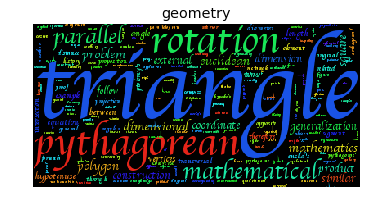

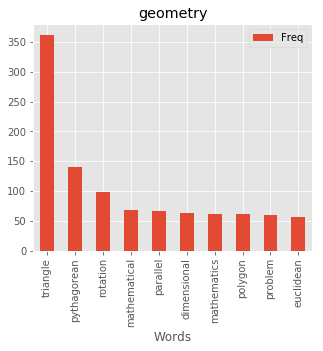

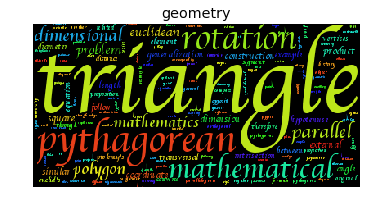

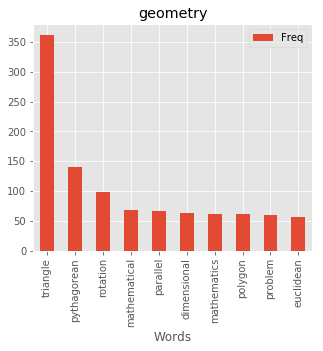

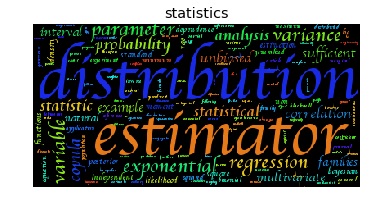

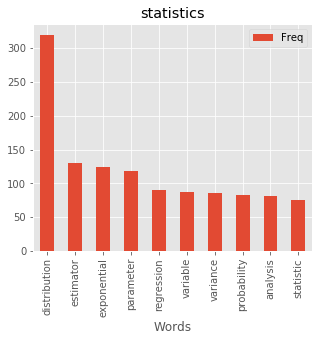

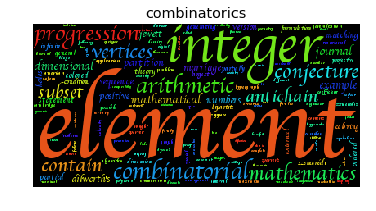

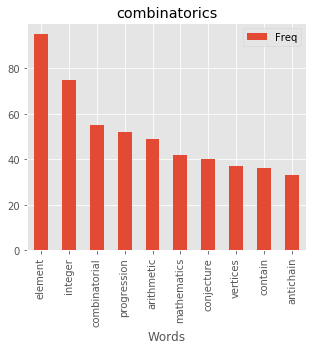

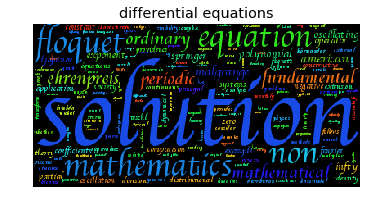

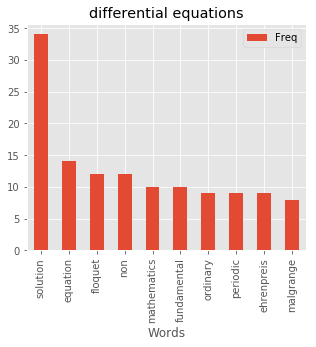

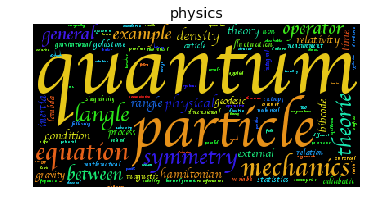

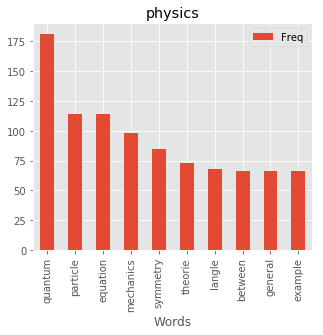

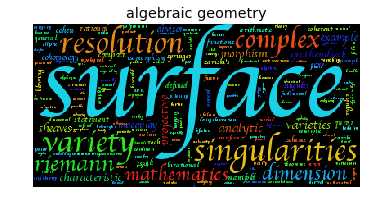

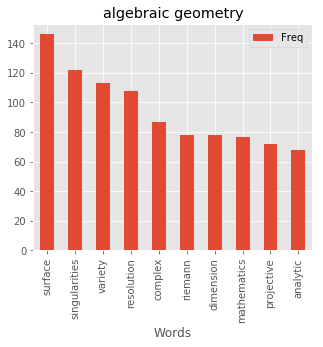

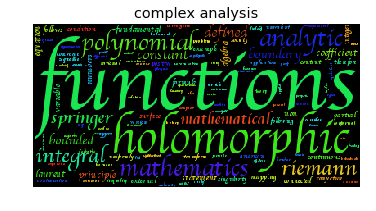

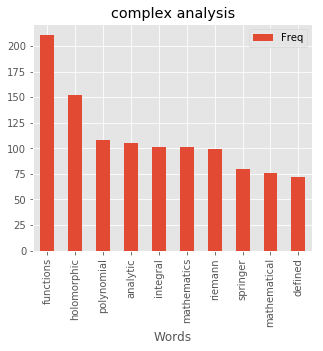

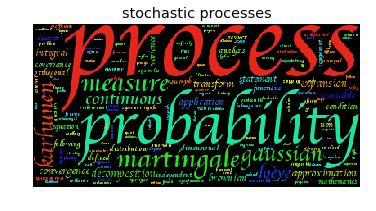

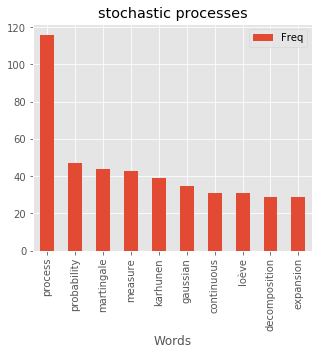

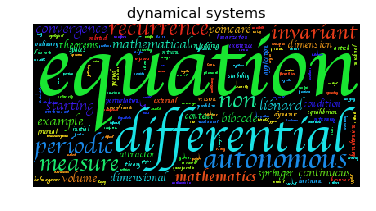

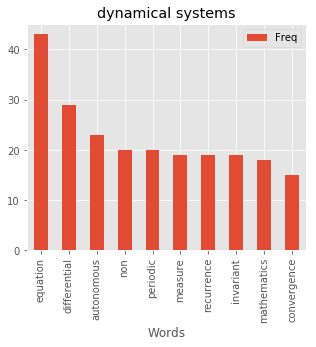

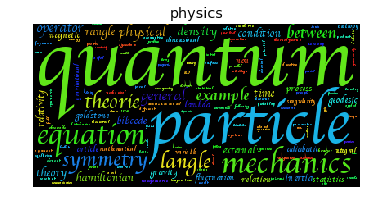

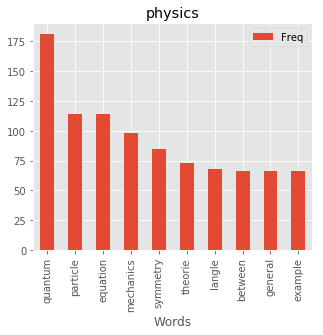

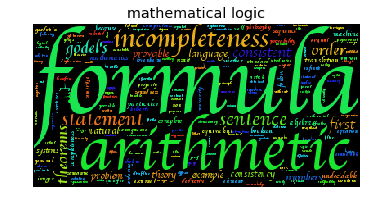

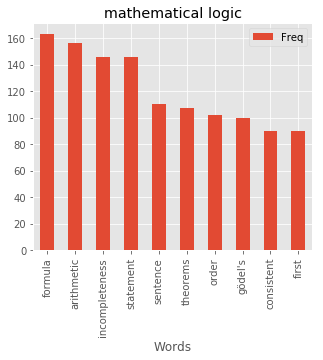

In [326]:
min_len = 6
these_fields = temp['Field'][0:12].values
for j in range(len(these_fields)):    
    field = these_fields[j]
    temp = duplicate_theorems[duplicate_theorems['Field']==field]
    f1,ax = plt.subplots(1,1,figsize = [15,3])
    txt=f(temp,ax,stopwords=stopwords,min_len=min_len)
    f2,ax = plt.subplots(1,1,figsize = [5,5])
    plt.gcf().subplots_adjust(bottom=0.25)
    txt[0:10].set_index('Words').plot(kind='bar',title=field,ax=ax)

    f1.savefig('plots/wordclouds/'+str(j)+'.png')
    f2.savefig('plots/bargraphs/'+str(j)+'.png')


In [297]:
def build_wordcloud(text,stopwords,ax=plt,title = ''):
    #,mode='RGBA',background_color='black',prefer_horizontal=.6,width=1000,height=600,
    wordcloud = WordCloud(stopwords = stopwords,font_path='/Library/Fonts/Apple Chancery.ttf').generate(text)
    ax.imshow(wordcloud)
    ax.axis("off")
    ax.show() if ax == plt else ''
    ax.set_title(title) if ax != plt else ''
    words = WordCloud(stopwords = stopwords).process_text(text)
    words = pd.DataFrame({'Words':words.keys(),'Freq':words.values()}).sort_values('Freq',ascending=0)    
    return(words)
def f(text,ax=plt,stopwords=[''],min_len=7): 
    title = text.iloc[0,0]
    texts = [y.lower() for y in text['Trimmed']]
    #texts = [y.lower() for y in text]
    words=build_wordcloud(stopwords=stopwords+title.split(' '),text=remove_small(texts,min_len),ax=ax,title=title)
    return(words)

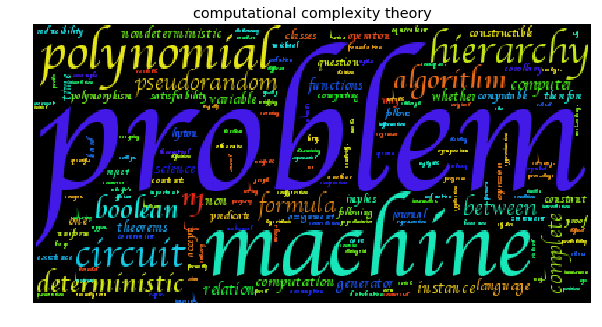

In [295]:
temp = duplicate_theorems[duplicate_theorems['Field']==field]
f1,ax = plt.subplots(1,1,figsize=[10,10])
_=f(temp,ax,stopwords=stopwords,min_len=min_len)
f1.savefig('temp3.png')

In [240]:
help(WordCloud)

Help on class WordCloud in module wordcloud.wordcloud:

class WordCloud(__builtin__.object)
 |  Word cloud object for generating and drawing.
 |  
 |  Parameters
 |  ----------
 |  font_path : string
 |      Font path to the font that will be used (OTF or TTF).
 |      Defaults to DroidSansMono path on a Linux machine. If you are on
 |      another OS or don't have this font, you need to adjust this path.
 |  
 |  width : int (default=400)
 |      Width of the canvas.
 |  
 |  height : int (default=200)
 |      Height of the canvas.
 |  
 |  prefer_horizontal : float (default=0.90)
 |      The ratio of times to try horizontal fitting as opposed to vertical.
 |  
 |  mask : nd-array or None (default=None)
 |      If not None, gives a binary mask on where to draw words. If mask is not
 |      None, width and height will be ignored and the shape of mask will be
 |      used instead. All white (#FF or #FFFFFF) entries will be considerd
 |      "masked out" while other entries will be free 